In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import stanza
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Initialize tools
nltk.download('punkt')
nltk.download('punkt_tab')
stanza.download('hi')  # Hindi support
stanza.download('en')  # English support

c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nnadg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nnadg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2024-11-26 20:01:04 INFO: Downloaded file to C:\Users\nnadg\stanza_resources\resources.json
2024-11-26 20:01:04 INFO: Downloading default packages for language: hi (Hindi) ...
2024-11-26 20:01:06 INFO: File exists: C:\Users\nnadg\stanza_resources\hi\default.zip
2024-11-26 20:01:08 INFO: Finished downloading models and saved to C:\Users\nnadg\stanza_resources
2024-11-26 20:01:08 INFO: Downloaded file to C:\U

In [2]:

# Load dataset
data = pd.read_csv('dev.enhi.df.short.tsv', sep='\t', names=['index','English', 'Hindi', 'scores', 'mean', 'z_scores', 'z_mean'], header=0)
data.dropna(inplace=True)  # Drop rows with missing data

# Initialize NLP pipelines
nlp_en = stanza.Pipeline('en')
nlp_hi = stanza.Pipeline('hi')

2024-11-26 20:02:43 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-11-26 20:02:43 INFO: Downloaded file to C:\Users\nnadg\stanza_resources\resources.json
2024-11-26 20:02:45 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-11-26 20:02:45 INFO: Using device: cpu
2024-11-26 20:02:45 INFO: Loading: tokenize
2024-11-26 20:02:45 INFO: Loading: mwt
2024-11-26 20:02:45 INFO: Loading: pos
20

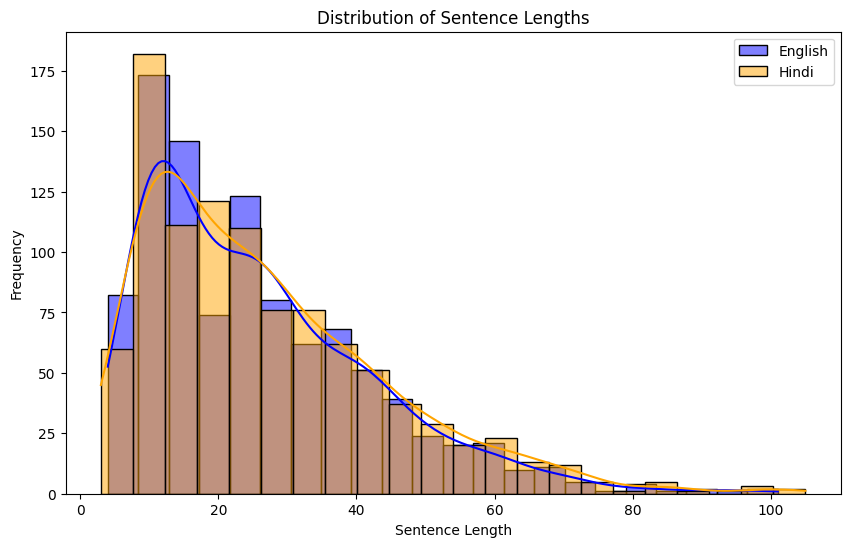

In [3]:
# 1. WORD ORDER ANALYSIS
# Tokenize sentences
data['English_Tokens'] = data['English'].apply(word_tokenize)
data['Hindi_Tokens'] = data['Hindi'].apply(word_tokenize)

# Calculate sentence lengths
data['English_Length'] = data['English_Tokens'].apply(len)
data['Hindi_Length'] = data['Hindi_Tokens'].apply(len)

# Visualization: Sentence Lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['English_Length'], kde=True, label="English", color="blue")
sns.histplot(data['Hindi_Length'], kde=True, label="Hindi", color="orange")
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.savefig('word_order.png')
plt.show()

In [ ]:
# 2. MORPHOLOGICAL AGREEMENT
# POS tagging for Hindi
def tag_hindi(sentence):
    doc = nlp_hi(sentence)
    return [(word.text, word.upos, word.feats) for sent in doc.sentences for word in sent.words]

data['Hindi_POS'] = data['Hindi'].apply(tag_hindi)

# Extract verbs and features
def extract_verbs(pos_tags):
    return [(word, feats) for word, upos, feats in pos_tags if upos == 'VERB']

data['Hindi_Verbs'] = data['Hindi_POS'].apply(extract_verbs)

# Visualize verb features (e.g., gender, number)
gender_counts = data['Hindi_Verbs'].explode().dropna().apply(lambda x: x[1].split('|') if x[1] else []).explode().value_counts()

plt.figure(figsize=(10, 6))
gender_counts.plot(kind='bar', color='purple')
plt.title("Distribution of Verb Features (Gender, Number, Tense)")
plt.ylabel("Count")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.savefig('verb_features.png')
plt.show()

In [ ]:
# 3. IDIOMATIC EXPRESSIONS
# Define idioms list (add more based on your data)
idiom_list = ['कलेजा थाम के रखना', 'दुनिया छोड़ दी']

# Find idioms in Hindi sentences
def contains_idiom(sentence):
    return [idiom for idiom in idiom_list if idiom in sentence]

data['Idioms'] = data['Hindi'].apply(contains_idiom)

# Translate idioms using a pre-trained model
translator = pipeline('translation', model='Helsinki-NLP/opus-mt-hi-en')

def translate_idiom(idiom):
    return translator(idiom)[0]['translation_text']

data['Idiom_Translations'] = data['Idioms'].apply(lambda idioms: [translate_idiom(i) for i in idioms] if idioms else [])

# Visualize idiom frequency
idiom_freq = data['Idioms'].explode().value_counts()

plt.figure(figsize=(10, 6))
idiom_freq.plot(kind='bar', color='green')
plt.title("Frequency of Idioms in the Dataset")
plt.ylabel("Count")
plt.xlabel("Idiom")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Save processed dataset for further analysis
data.to_csv('processed_dataset.csv', index=False)

print("Processing complete. Processed dataset saved as 'processed_dataset.csv'.")